# Assignment 7 - Text Processing (Group)
*Daniel Lu, Wanyu Guan, Markus Shriner*

In [1]:
# Import libraries
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.formula as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

## 1. Explore the data


### 1.1 Load the data. You may drop size, lines, and pagenr.

In [2]:
#Load the data 
tx = pd.read_csv("./texts.csv.bz2", sep="\t")
tx.drop(columns=["size", "lines", "pagenr"], inplace=True)
tx.head(5)

,name,text
0,balbulus-early-life-charlemagne,\nTitle: Early Lives of Charlemagne by Eginhar...
1,balbulus-early-life-charlemagne,"\n\nThe notes, keyed to line numbers in the so..."
2,balbulus-early-life-charlemagne,\n From a bronze statuette in the Musé...
3,balbulus-early-life-charlemagne,\n _A lui finit la dissolution ...
4,balbulus-early-life-charlemagne,public opinion in regard to the meaning of fal...


### 1.2 Ensure that you don't have any missing name, and empty text in your data.

In [3]:
tx.isna().sum()

name    0
text    1
dtype: int64

In [4]:
tx.dropna(inplace=True)

In [5]:
tx.isna().sum()

name    0
text    0
dtype: int64

### 1.3 Create a summary table where you show how many chunks of each book you have in data. Order this by size.


In [6]:
tx.groupby('name').count().sort_values(by='text', ascending=False)

,text
name,
cia-world-factbook-1992,2822
bible,1321
webster-early-european-history,1265
vaneeden-quest,864
hardy-madding-crowd,723
why-speech-output,680
selected-polish-tales,534
unamuno-tragic-sense-of-life,519
naval-academy-sound-military-decision,485


### 1.4 Explore the data: check out a few pages from various titles, as a minimum take a look how do a few books and a few CS papers look like

In [7]:
tx[tx['name'] == 'bible'][:2]

,name,text
477,bible,In the beginning God created the heaven and th...
478,bible,And God made the beast of the earth after his ...


In [8]:
tx[tx.name.str.contains('paper')][:2]

,name,text
8380,paper-compact-hash-tables,".EQ\ndelim $$\ndefine <- ?< ""\h'-0.5m'"" up 10 ..."
8381,paper-compact-hash-tables,"define elseif '""\fBelseif\fI""~' \ndefine for '..."


## 2. First Task: Tokenize

### 2.1 Convert all texts to lower case


In [9]:
tx.text = tx.text.str.lower()
tx.text

0        \ntitle: early lives of charlemagne by eginhar...
1        \n\nthe notes, keyed to line numbers in the so...
2        \n         from a bronze statuette in the musé...
3        \n                _a lui finit la dissolution ...
4        public opinion in regard to the meaning of fal...
                               ...                        
12919         descriptive cataloging division lm 540\n ...
12920         james graber\n     information technology...
12921    \n     john w. kimball, jr\n     machine-reada...
12922         (202) 707-7706\n\n     chandru j. shahani...
12923         preservation microfilming office lm g05\n...
Name: text, Length: 12923, dtype: object

### 2.2 Remove punctuation and other weird characters. I recommend to replace these with space.

In [10]:
# tx.text = tx.text.map(lambda x: re.sub(r'\W+', ' ', x))
tx.text = tx.text.map(lambda x: re.sub('[^a-z0-9]+', ' ', x))
# tx.text.map(lambda x: print('$$$' + x))

In [11]:
# punk = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
# punk

In [12]:
# tx.text = tx.text.str.translate(str.maketrans(punk, ' '*len(punk))) 

In [13]:
tx.text

0         title early lives of charlemagne by eginhard ...
1         the notes keyed to line numbers in the source...
2         from a bronze statuette in the mus e carnaval...
3         a lui finit la dissolution de l ancien monde ...
4        public opinion in regard to the meaning of fal...
                               ...                        
12919     descriptive cataloging division lm 540 202 70...
12920     james graber information technology services ...
12921     john w kimball jr machine readable collection...
12922     202 707 7706 chandru j shahani preservation r...
12923     preservation microfilming office lm g05 202 7...
Name: text, Length: 12923, dtype: object

### 2.3 Tokenize texts to words. If you replaced punctuation with spaces, you can just use pandas' str.split method.


In [14]:
tx.text = tx.text.str.split()

In [15]:
tx.text

0        [title, early, lives, of, charlemagne, by, egi...
1        [the, notes, keyed, to, line, numbers, in, the...
2        [from, a, bronze, statuette, in, the, mus, e, ...
3        [a, lui, finit, la, dissolution, de, l, ancien...
4        [public, opinion, in, regard, to, the, meaning...
                               ...                        
12919    [descriptive, cataloging, division, lm, 540, 2...
12920    [james, graber, information, technology, servi...
12921    [john, w, kimball, jr, machine, readable, coll...
12922    [202, 707, 7706, chandru, j, shahani, preserva...
12923    [preservation, microfilming, office, lm, g05, ...
Name: text, Length: 12923, dtype: object

### 2.4 Remove stopwords. It is up to you to decide which stopwords to remove, I recommend to include at least the and a.


In [16]:
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once',
                  'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for',
                  'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is',
                  's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until',
                  'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were',
                  'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above',
                  'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before',
                  'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then',
                  'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he',
                  'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i',
                  'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing',
                  'it', 'how', 'further', 'was', 'here', 'than', '\x1a']

tx.text = tx['text'].apply(lambda x: [token for token in x if token not in stop_words])
tx.head(5)

,name,text
0,balbulus-early-life-charlemagne,"[title, early, lives, charlemagne, eginhard, m..."
1,balbulus-early-life-charlemagne,"[notes, keyed, line, numbers, source, edition,..."
2,balbulus-early-life-charlemagne,"[bronze, statuette, mus, e, carnavalet, paris,..."
3,balbulus-early-life-charlemagne,"[lui, finit, la, dissolution, de, l, ancien, m..."
4,balbulus-early-life-charlemagne,"[public, opinion, regard, meaning, falsehood, ..."


### 2.5 Create such vocabulary and order it alphabetically

In [17]:
vocab = set()
for i in range(len(tx.text)):
    vocab|=set(tx.text.iat[i])
# vocab |= set(tx.text.iat[i] for i in range(len(tx.text)))
vocab = sorted(vocab)

In [18]:
vocab[:10]

['0',
 '00',
 '000',
 '0000',
 '00000',
 '00000000000test',
 '00006',
 '0001',
 '0002',
 '00021']

## 3. Implement BOW

### Using CountVectorizer


In [19]:
tx.text = tx.text.apply(lambda x: ' '.join(map(str, x)))

In [20]:
tx.text[:5]

0    title early lives charlemagne eginhard monk st...
1    notes keyed line numbers source edition conver...
2    bronze statuette mus e carnavalet paris early ...
3    lui finit la dissolution de l ancien monde lui...
4    public opinion regard meaning falsehood obliga...
Name: text, dtype: object

In [21]:
vrizer = CountVectorizer()
r = vrizer.fit(tx.text) 
X = vrizer.transform(tx.text)
df = pd.DataFrame(X.toarray(), columns= vrizer.get_feature_names())
print(df[:3])

   00  000  0000  00000  00000000000test  00006  0001  0002  00021  00021053  \
0   0    0     0      0                0      0     0     0      0         0   
1   0    0     0      0                0      0     0     0      0         0   
2   0    0     0      0                0      0     0     0      0         0   

   ...  zurbuchen  zurich  zuriel  zurishaddai  zuta  zuzims  zviad  zwingli  \
0  ...          0       0       0            0     0       0      0        0   
1  ...          0       0       0            0     0       0      0        0   
2  ...          0       0       0            0     0       0      0        0   

   zx  zzassgl  
0   0        0  
1   0        0  
2   0        0  

[3 rows x 63229 columns]


## 4. Model

### 4.1. split your data into training/testing chunks. Remember: BOW is your data matrix (design matrix) and name is your target variable. 

In [22]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, tx.name.values, test_size=0.2)

### 4.2. pick a k and use cosine similarity.

In [23]:
k = 3

In [24]:
m = KNeighborsClassifier(n_neighbors=k, metric='cosine')

### 4.3. fit your model on training data...

In [25]:
m.fit(Xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

### 4.4. ...and predict on validation data. Again, this may be slow, so please start small and only increase your sample size if the speed is sufficient. 

In [26]:
yhat = m.predict(Xvalid)

### 4.5. compute accuracy on validation data. As we have 29 categories now you probably don't want to print a confusion matrix. Instead, just count the correct vs incorrect predictions.

In [27]:
predictions = yhat == yvalid 
accuracy = np.mean(predictions)
print(accuracy)

0.8765957446808511


### 4.6. try different k-s, and try different metrics. 

In [28]:
# function to calculating the accuracy 
def computeAccuracy(k_value, metric):
    Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, tx.name.values, test_size=0.2)
    k = k_value
    m = KNeighborsClassifier(n_neighbors=k, metric=metric)
    m.fit(Xtrain, ytrain)
    yhat = m.predict(Xvalid)
    predictions = yhat == yvalid 
    accuracy = np.mean(predictions)
    return accuracy

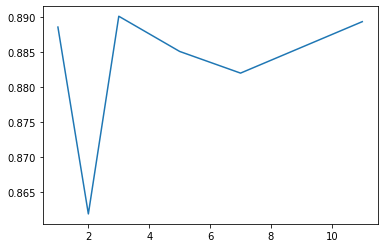

In [29]:
klist = [1,2,3,5,7,11]
accuracy = pd.Series(0.0, index=klist)
for k in klist:
    a = computeAccuracy(k, 'cosine')
    accuracy[k] = a
plt.plot(klist, accuracy)

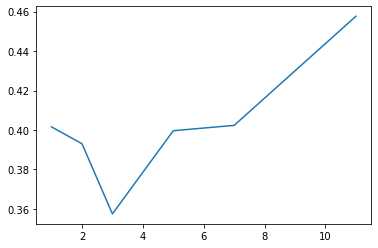

In [30]:
klist = [1,2,3,5,7,11]
accuracy = pd.Series(0.0, index=klist)
for k in klist:
    a = computeAccuracy(k, 'euclidean')
    accuracy[k] = a
plt.plot(klist, accuracy)

### 4.7. Print out a few correct and incorrect predictions. Can you understand what is going on? Note: if you do TF-IDF then answer this question after you are done with that. 

## 5. Implement TF-IDF transformation (10 EC points)


### 5.1 Implement TF-IDF transformation

In [31]:
tf = np.log(1 + df)
idf = np.log(X.shape[0]/(1 + (df > 0).sum(axis=0)))
tfidf = tf * idf
tfidf

,00,000,0000,00000,00000000000test,00006,0001,0002,00021,00021053,...,zurbuchen,zurich,zuriel,zurishaddai,zuta,zuzims,zviad,zwingli,zx,zzassgl
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5.2 Repeat Q4 with TF-IDF version of the data

In [40]:
import scipy
tfsp = scipy.sparse.csr_matrix(tfidf.values)

In [41]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(tfsp, tx.name.values, test_size=0.2)

In [42]:
k = 5
m = KNeighborsClassifier(n_neighbors=k, metric='cosine')

In [43]:
m.fit(Xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [44]:
yhat = m.predict(Xvalid)

In [45]:
predictions = yhat == yvalid 
accuracy = np.mean(predictions)
print(accuracy)

0.969825918762089


In [46]:
# function to calculating the accuracy 
def computeAccuracy(k_value, metric):
    Xtrain, Xvalid, ytrain, yvalid = train_test_split(tfsp, tx.name.values, test_size=0.2)
    k = k_value
    m = KNeighborsClassifier(n_neighbors=k, metric=metric)
    m.fit(Xtrain, ytrain)
    yhat = m.predict(Xvalid)
    predictions = yhat == yvalid 
    accuracy = np.mean(predictions)
    return accuracy

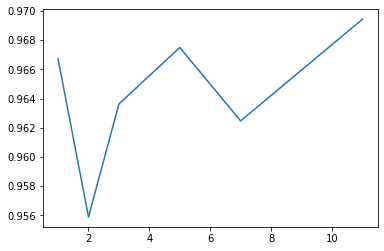

In [47]:
klist = [1,2,3,5,7,11]
accuracy = pd.Series(0.0, index=klist)
for k in klist:
    a = computeAccuracy(k, 'cosine')
    accuracy[k] = a
plt.plot(klist, accuracy)

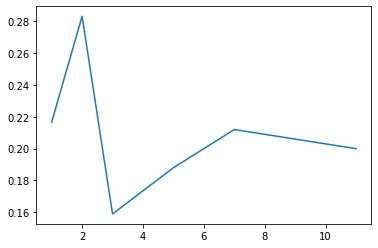

In [51]:
klist = [1,2,3,5,7,11]
accuracy = pd.Series(0.0, index=klist)
for k in klist:
    a = computeAccuracy(k, 'euclidean')
    accuracy[k] = a
plt.plot(klist, accuracy)

### 5.3 Compare BOW and TF-IDF results. Which ones are better?

### 5.4 Now it is time to do the last question of the previous section.